In [1]:
import pandas as pd

metadata_df = pd.read_csv("/home/zhenhao/metadata_with_taxid.csv")

/tmp/ipykernel_1981/2811069003.py:3: DtypeWarning: Columns (62,64,66,75,83,84) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv("/home/zhenhao/metadata_with_taxid.csv")


In [2]:
import os

def extract_refseq_accession_from_genome_file_name(genome_file_name):
    basename = os.path.basename(genome_file_name)
    accession = "_".join(basename.split("_")[:2])
    return "RS_" + accession


def accession_to_species_name(accession, type="ncbi_genbank_assembly_accession", identifier="species_taxid"):
    """
    type is either "ncbi_genbank_assembly_accession" or "accession" (RefSeq accession).
    identifier is either "[species/genus/family]_taxid" or "[species/genus/family]_name"
    """
    sample_df = metadata_df[metadata_df[type] == accession]
    if len(sample_df) != 1:
        return None
    return sample_df.iloc[0][identifier]

In [8]:
import numpy as np

coverages = [0.008, 0.015, 0.0284, 0.0535, 0.101, 0.1902, 0.3585, 0.6757]
sylph_output_dir = "/home/zhenhao/tc-benchmark/output/sylph_sensitivity_output_c_20/"
data_dir = "/home/zhenhao/tc-benchmark/data/sensitivity_test/"
res = {}

for coverage in coverages:
    # Read ground truth
    ground_truth_df = pd.read_csv(data_dir + "other_coverage_" + str(coverage) + "_abundance.csv")
    ground_truth_species_name = [accession_to_species_name(i, identifier="species_name") for i in ground_truth_df["accession"]]
    ground_truth_species_id = [accession_to_species_name(i, identifier="species_taxid") for i in ground_truth_df["accession"]]
    ground_truth_df = pd.DataFrame({"species_name": ground_truth_species_name,
                                    "species_id": ground_truth_species_id, 
                                    "true_coverage": [coverage] * len(ground_truth_species_name)})
    
    # Results of sylph query
    try:
        sylph_query_results_df = pd.read_csv(sylph_output_dir + "query_other_" + str(coverage) + ".tsv", sep='\t')
        sylph_query_results_df["species_name"] = [accession_to_species_name(
                                         extract_refseq_accession_from_genome_file_name(i), type="accession", identifier="species_name"
                                    ) for i in sylph_query_results_df["Genome_file"]]
        sylph_query_results_df["species_id"] = [accession_to_species_name(
                                         extract_refseq_accession_from_genome_file_name(i), type="accession", identifier="species_taxid"
                                  ) for i in sylph_query_results_df["Genome_file"]]
    except:
        continue
    
    # Find sensitivity
    ANI_res = []
    cov_res = []
    for i in range(len(ground_truth_df)):
        # Check if the species is in the query results
        species_name = ground_truth_df.iloc[i]["species_name"]
        species_id = ground_truth_df.iloc[i]["species_id"]
        
        # Find the corresponding rows in query results
        sub_df = sylph_query_results_df[(sylph_query_results_df["species_name"] == species_name) | (sylph_query_results_df["species_id"] == species_id)]
        max_estimated_ANI = 0 if len(sub_df) == 0 else np.max(sub_df["Adjusted_ANI"])
        avg_estimated_coverage = 0 if len(sub_df) == 0 else np.average(sub_df["Eff_cov"])

        ANI_res.append(max_estimated_ANI)
        cov_res.append(avg_estimated_coverage)

    # Results of sylph profile
    #try:
    #    sylph_profile_results_df = pd.read_csv(sylph_output_dir + "profile_" + str(coverage) + ".tsv", sep='\t')
    #    sylph_profile_species = [accession_to_species_name(extract_refseq_accession_from_genome_file_name(i), type="accession") for i in sylph_profile_results_df["Genome_file"]]
    #    sylph_profile_coverage = sylph_profile_results_df["Eff_cov"]
    #except:
    #    sylph_profile_species = []
    #    sylph_profile_coverage = []
    
    ## Sensitivity
    sensitivity_95 = np.average(np.array(ANI_res) > 95)
    sensitivity_90 = np.average(np.array(ANI_res) > 90)
    sensitivity_80 = np.average(np.array(ANI_res) > 80)
    coverage_l1 = np.sum(np.abs(ground_truth_df["true_coverage"] - np.array(cov_res)))

    # Calculate metrics
    #query_sensitivity = len(set(ground_truth_species).intersection(set(sylph_query_species))) / len(set(ground_truth_species))
    #profile_sensitivity = len(set(ground_truth_species).intersection(set(sylph_profile_species))) / len(set(ground_truth_species))
    res[coverage] = (sensitivity_95, sensitivity_90, sensitivity_80, coverage_l1)
    print(coverage, "sensitivity:", sensitivity_95, sensitivity_90, sensitivity_80, coverage_l1)

0.008 sensitivity: 0.014925373134328358 0.07462686567164178 0.8059701492537313 48.95308035714285
0.015 sensitivity: 0.208955223880597 0.2537313432835821 0.7910447761194029 37.331148639455776
0.0284 sensitivity: 0.44776119402985076 0.4925373134328358 0.8208955223880597 22.917989435774306
0.0535 sensitivity: 0.6865671641791045 0.7761194029850746 0.8208955223880597 9.420814075630252
0.101 sensitivity: 0.7910447761194029 0.8059701492537313 0.835820895522388 5.637998734039072
0.1902 sensitivity: 0.7910447761194029 0.8059701492537313 0.835820895522388 6.0087581232493
0.3585 sensitivity: 0.7910447761194029 0.8059701492537313 0.835820895522388 8.435167597038816
0.6757 sensitivity: 0.7910447761194029 0.8059701492537313 0.835820895522388 13.591833823529413


## `k = 21`

```
0.008 sensitivity: 0.0 0.04477611940298507 0.23880597014925373 12.561999999999998
0.015 sensitivity: 0.1044776119402985 0.14925373134328357 0.7164179104477612 35.526999999999994
0.0284 sensitivity: 0.3283582089552239 0.417910447761194 0.7910447761194029 25.294541666666664
0.0535 sensitivity: 0.582089552238806 0.7164179104477612 0.8059701492537313 8.810255147058825
0.101 sensitivity: 0.7611940298507462 0.8059701492537313 0.8208955223880597 4.249144097639055
0.1902 sensitivity: 0.7761194029850746 0.8059701492537313 0.835820895522388 5.977982933173269
0.3585 sensitivity: 0.7910447761194029 0.8059701492537313 0.835820895522388 9.770990556222491
0.6757 sensitivity: 0.7910447761194029 0.8059701492537313 0.835820895522388 14.18137148859544
```

In [9]:
sensitivity_95_list = [res[i][0] for i in coverages]
sensitivity_90_list = [res[i][1] for i in coverages]
sensitivity_80_list = [res[i][2] for i in coverages]
coverage_l1_list = [res[i][3] for i in coverages]

res_df = pd.DataFrame({"coverage": coverages, "sensitivity_95_ANI": sensitivity_95_list, "sensitivity_90_ANI": sensitivity_90_list, "sensitivity_80_ANI": sensitivity_80_list, "coverage_l1_error":coverage_l1_list})

Text(0, 0.5, 'Coverage L1 error')

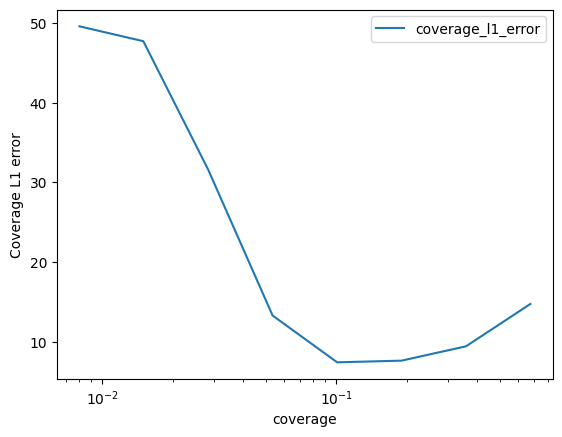

In [5]:
import seaborn
import matplotlib.pyplot as plt

seaborn.lineplot(data=res_df[["coverage_l1_error", "coverage"]].set_index("coverage"))
plt.xscale('log')
plt.ylabel('Coverage L1 error')
#sensitivity_95_list

Text(0, 0.5, 'Sensitivity')

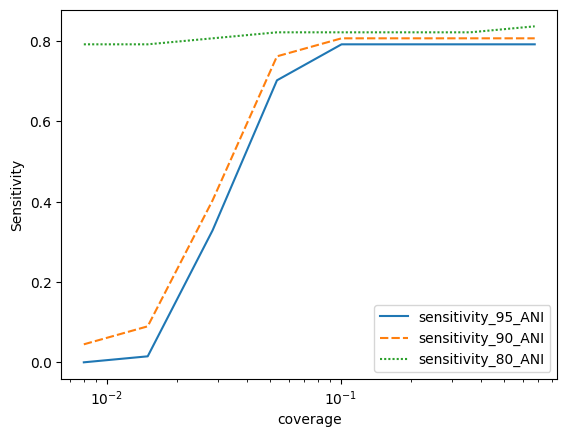

In [6]:
seaborn.lineplot(data=res_df[["sensitivity_95_ANI", "sensitivity_90_ANI", "sensitivity_80_ANI", "coverage"]].set_index("coverage"))
plt.xscale('log')
plt.ylabel('Sensitivity')

In [7]:
import copy

original_results = copy.deepcopy(sensitivity_95_list)
original_results

[0.0,
 0.014925373134328358,
 0.3283582089552239,
 0.7014925373134329,
 0.7910447761194029,
 0.7910447761194029,
 0.7910447761194029,
 0.7910447761194029]

In [10]:
c_20_results = copy.deepcopy(sensitivity_95_list)
c_20_results

[0.014925373134328358,
 0.208955223880597,
 0.44776119402985076,
 0.6865671641791045,
 0.7910447761194029,
 0.7910447761194029,
 0.7910447761194029,
 0.7910447761194029]

In [13]:
k_21_results = [0.0, 0.1044776119402985 ,0.3283582089552239, 0.582089552238806,0.7611940298507462 ,0.7761194029850746 ,0.7910447761194029, 0.7910447761194029]

In [16]:
compare_df = pd.DataFrame({"Default": original_results, "c = 20": c_20_results, "k = 21": k_21_results, "coverage": coverages})

Text(0, 0.5, 'sensitivity')

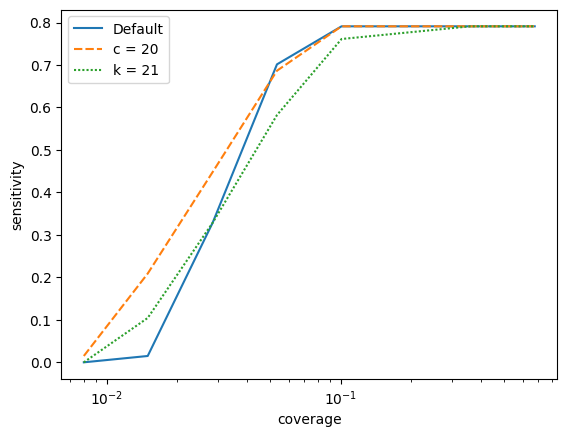

In [18]:
seaborn.lineplot(data=compare_df.set_index("coverage"))
plt.xscale('log')
plt.ylabel('sensitivity')